# Mira
## Quantum Sudoku Solver

### Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from IPython.display import clear_output
import os

In [2]:
%pip install qiskit
%pip install qiskit[visualization]
%pip install pylatexenc
%pip install tabulate

for i in range(100):
    clear_output(True)
os.system('clear')

1

In [3]:
from tabulate import tabulate

from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram

### Helpers

In [4]:
DRAW_FORMAT = 'mpl'

In [5]:
def display_qc(qc):
    display(qc.draw(DRAW_FORMAT, fold=-1))

#### Sudoku Analyzer

In [6]:
class Sudoku:
    def __loc_id(self, r, c):
        return r * self.size + c

    def __get_unknowns(self):
        unknowns = []
        for r in range(self.size):
            for c in range(self.size):
                if self.puzzle[r][c] == -1:
                    unknowns.append((r, c))
        return unknowns

    def __to_bin(self, val):
        b = bin(val)[2:][::-1]
        return b.ljust(2, '0')

    def __merge(self, states:list) -> str:
        assert len(states)
        res = states[0]
        for state in states[1:]:
            res = self.__superimpose(res, state)
        return res

    def __superimpose(self, a, b):
        assert len(a) == len(b)
        superposition = ''
        for i in range(len(a)):
            superposition += a[i] if a[i] == b[i] else '?'
        return superposition

    def __get_candidates(self):
        candidates = {}
        for (r, c) in self.unknowns:
            candidates[(r, c)] = self.__get_candidates_util(r, c)
        return candidates

    def __get_candidates_util(self, r, c):
        assert puzzle[r][c] == -1
        candidates = set([i for i in range(self.size)])

        for i in range(self.size):
            candidates.discard(puzzle[r][i])
            candidates.discard(puzzle[i][c])

        _r = r - r % self.sq_size
        _c = c - c % self.sq_size
        moves = [
            (0, 0),
            (0, 1),
            (1, 0),
            (1, 1)
        ]
        for dr, dc in moves:
            nr = _r + dr
            nc = _c + dc
            candidates.discard(puzzle[nr][nc])

        return candidates

    def __get_clauses(self) -> list:
        clauses = set()
        for (r, c) in self.unknowns:
            assert puzzle[r][c] == -1

            for i in range(self.size):
                if puzzle[r][i] == -1 and not self.candidates[(r, i)].isdisjoint(self.candidates[(r, c)]):
                    clauses.add(tuple(sorted([
                        self.unknowns.index((r, c)),
                        self.unknowns.index((r, i))
                    ])))
                if puzzle[i][c] == -1 and not self.candidates[(i, c)].isdisjoint(self.candidates[(r, c)]):
                    clauses.add(tuple(sorted([
                        self.unknowns.index((r, c)),
                        self.unknowns.index((i, c))
                    ])))

            _r = r - r % self.sq_size
            _c = c - c % self.sq_size
            moves = [
                (0, 0),
                (0, 1),
                (1, 0),
                (1, 1)
            ]
            for dr, dc in moves:
                nr = _r + dr
                nc = _c + dc
                if puzzle[nr][nc] == -1 and not self.candidates[(nr, nc)].isdisjoint(self.candidates[(r, c)]):
                    clauses.add(tuple(sorted([
                        self.unknowns.index((r, c)),
                        self.unknowns.index((nr, nc))
                    ])))
        
        clauses = [(i, j) for (i, j) in clauses if i != j]
        clauses = [(i, j) for (i, j) in clauses if '?' in {self.mask[2 * i], self.mask[2 * i + 1], self.mask[2 * j], self.mask[2 * j + 1]}]
        clauses = [(i, j) for (i, j) in clauses if not ((self.mask[2 * i], self.mask[2 * j]) in [('0', '1'), ('1', '0')])]
        clauses = [(i, j) for (i, j) in clauses if not ((self.mask[2 * i + 1], self.mask[2 * j + 1]) in [('0', '1'), ('1', '0')])]
        return clauses

    def __find_mask(self):
        mask = ''
        for (r, c) in self.unknowns:
            assert self.puzzle[r][c] == -1
            mask += self.__merge([self.__to_bin(cand) for cand in self.candidates[(r, c)]])

        self.unknown_bits = [i for i in range(len(mask)) if mask[i] == '?']
        if len(self.unknown_bits) == 1:
            puzzle = self.puzzle
            for idx, (r, c) in enumerate(self.unknowns):
                if len(self.candidates[(r, c)]) == 1:
                    puzzle[r][c] = list(self.candidates[(r, c)])[0]
            self.__init__(puzzle)
            return self.__find_mask()

        return mask

    def __init__(self, puzzle):
        self.puzzle = puzzle
        assert len(puzzle) and len(puzzle) == len(puzzle[0])
        self.size = len(puzzle)
        self.sq_size = int(math.sqrt(self.size))
        self.unknowns = self.__get_unknowns()
        self.num_unknowns = len(self.unknowns)
        self.candidates = self.__get_candidates()
        self.mask = self.__find_mask()
        self.clauses = self.__get_clauses()

    def fill(self, soln):
        assert len(soln) == self.num_unknowns
        for idx, (r, c) in enumerate(self.unknowns):
            puzzle[r][c] = soln[idx]

    def is_valid(self):
        valid_fills = set(range(self.size))

        for i in range(self.size):
            tmp = set()
            for j in range(self.size):
                assert puzzle[i][j] in valid_fills
                tmp.add(puzzle[i][j])
            if len(tmp) != self.size:
                return False

        for i in range(self.size):
            tmp = set()
            for j in range(self.size):
                assert puzzle[j][i] in valid_fills
                tmp.add(puzzle[j][i])
            if len(tmp) != self.size:
                return False

        corners = [
            (0, 0),
            (0, 2),
            (2, 0),
            (2, 2)
        ]
        moves = [
            (0, 0),
            (0, 1),
            (1, 0),
            (1, 1)
        ]
        for (r, c) in corners:
            tmp = set()
            for dr, dc in moves:
                nr = r + dr
                nc = c + dc
                assert puzzle[nr][nc] in valid_fills
                tmp.add(puzzle[nr][nc])
            if len(tmp) != self.size:
                return False

        return True

    def __repr__(self):
        return tabulate(self.puzzle, tablefmt='fancy_grid')


puzzle = [
    [3, 0, 2, -1],
    [2, 1, -1, 3],
    [-1, 3, -1, 2],
    [1, 2, 3, -1]
]

sudoku = Sudoku(puzzle)

In [7]:
print(sudoku)

╒═══╤═══╤════╤═══╕
│ 3 │ 0 │  2 │ 1 │
├───┼───┼────┼───┤
│ 2 │ 1 │  0 │ 3 │
├───┼───┼────┼───┤
│ 0 │ 3 │ -1 │ 2 │
├───┼───┼────┼───┤
│ 1 │ 2 │  3 │ 0 │
╘═══╧═══╧════╧═══╛


In [8]:
print(sudoku.clauses)

[]


In [9]:
print(sudoku.candidates)

{(2, 2): {1}}


In [10]:
print(sudoku.mask)

10


#### Number of Turns

#### NotEqual Gate

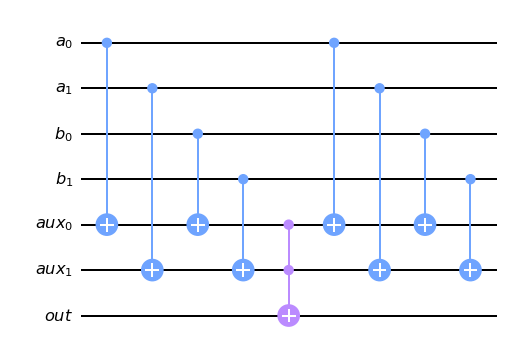

Instruction(name='NE', num_qubits=7, num_clbits=0, params=[])

In [11]:
def not_equal(display_gate=False):
	a = QuantumRegister(2, name='a')
	b = QuantumRegister(2, name='b')
	aux = QuantumRegister(2, name='aux')
	out = QuantumRegister(1, name='out')
	
	qc = QuantumCircuit(a, b, aux, out)

	# qc.x(aux)
	# qc.x(out)

	qc.cx(a[0], aux[0])
	qc.cx(b[0], aux[0])

	qc.cx(a[1], aux[1])
	qc.cx(b[1], aux[1])

	qc.ccx(aux[0], aux[1], out)

	qc.cx(a[0], aux[0])
	qc.cx(b[0], aux[0])
	
	qc.cx(a[1], aux[1])
	qc.cx(b[1], aux[1])

	# qc.x(aux)

	if display_gate:
		display_qc(qc)
  	
	U = qc.to_gate()
	U.name = 'NE'
  	
	return U

not_equal(True)

#### Oracle

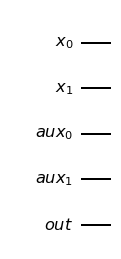

In [12]:
class Oracle:
    def __init__(self, sudoku:Sudoku):
        n = sudoku.num_unknowns * 2

        x = QuantumRegister(n, name='x')
        aux = QuantumRegister(2, name='aux')
        check = QuantumRegister(len(sudoku.clauses), name='check')
        out = QuantumRegister(1, name='out')

        self.qc = QuantumCircuit(x, aux, check, out)

        def is_valid():
            for idx, (i, j) in enumerate(sudoku.clauses):
                self.qc.append(not_equal(), [
                    2 * i,
                    2 * i + 1,
                    2 * j,
                    2 * j + 1,
                    aux0,
                    aux1,
                    check0 + idx
                ])

        aux0 = n
        aux1 = aux0 + 1

        check0 = aux1 + 1
        
        is_valid()

        if len(check):
            self.qc.mct(check, out)

        is_valid()


        self.gate = self.qc.to_gate()
        self.gate.name = '$U_f$'

oracle = Oracle(sudoku)

display_qc(oracle.qc)

#### Diffuser

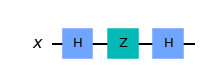

In [13]:
class Diffuser:
  def __init__(self, n):
    x = QuantumRegister(n, 'x')
    
    self.qc = QuantumCircuit(x)

    self.qc.h(x)

    # R0
    if n == 1:
      self.qc.z(x)
    else:
      self.qc.x(x)
      self.qc.h(x[n - 1])
      self.qc.mct(list(range(n - 1)), n - 1)
      self.qc.h(n - 1)
      self.qc.x(x)

    self.qc.h(x)
    
    self.gate = self.qc.to_gate()
    self.gate.name = 'R$_s$'

display_qc(Diffuser(1).qc)

10
1


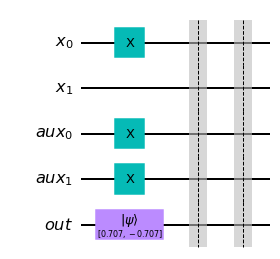

In [14]:
class SudokuSolver:
    # theta(t) = (2t+1) * theta = pi/2
    # sin(theta) = 1/sqrt(N)
    # N = 2^n
    def num_turns(self, n):
        if n < 2:
            return 0
        elif n == 2:
            return 1
        N = 1 << n
        theta = math.asin(1 / N**(1/2))
        t = int((math.pi / (2 * theta) - 1) / 2)
        return t

    def process_results(self, counts) -> list:
        state = max(zip(counts.values(), counts.keys()))[1]
        
        mask = sudoku.mask[::-1]
        tmp = ""
        i = 0
        for j in range(len(mask)):
            if mask[j] == '?':
                tmp += state[i]
                i = i + 1
            else:
                tmp += mask[j]
        state = tmp

        soln = []
        i = 0
        while i < len(state):
            soln.append(int(state[i:i+2], 2))
            i = i + 2
        soln.reverse()
        return soln

    def __init__(self, sudoku:Sudoku):
        n = sudoku.num_unknowns * 2
        print(sudoku.num_unknowns)
        
        unknown_bits = [i for i in range(len(sudoku.mask)) if sudoku.mask[i] == '?']
        self._n = len(unknown_bits)

        x = QuantumRegister(n, name='x')
        aux = QuantumRegister(2, name='aux')
        check = QuantumRegister(len(sudoku.clauses), name='check')
        out = QuantumRegister(1, name='out')
        soln =  ClassicalRegister(self._n, name='soln')

        self.qc = QuantumCircuit(x, aux, check, out, soln)

        self.qc.x(aux)
        if check:
            self.qc.x(check)
        self.qc.initialize([1, -1] / np.sqrt(2), out)

        # self.qc.h(x)
        for i in range(n):
            if sudoku.mask[i] == '?':
                self.qc.h(x[i])
            elif sudoku.mask[i] == '1':
                self.qc.x(x[i])

        self.qc.barrier()

        self.oracle = Oracle(sudoku)
        self.diff = None
        if self._n:
            self.diff = Diffuser(self._n)

        self.t = self.num_turns(self._n)
        for i in range(self.t):
            self.qc.append(self.oracle.gate, list(range(self.qc.num_qubits)))
            self.qc.append(self.diff.gate, unknown_bits)

        self.qc.barrier()

        self.qc.measure(unknown_bits, soln)

puzzle = [
    [3, 0, 2, -1],
    [2, 1, -1, 3],
    [-1, 3, -1, 2],
    [1, 2, 3, -1]
]

sudoku = Sudoku(puzzle)

print(sudoku.mask)
display_qc(SudokuSolver(sudoku).qc)

### Execution

#### Test

In [21]:
puzzle = [
    [3, 0, 2, 1],
    [2, 1, -1, 3],
    [-1, -1, -1, 2],
    [-1, 2, -1, 0]
]
sudoku = Sudoku(puzzle)

print(sudoku)
print(sudoku.mask)

╒════╤════╤════╤═══╕
│  3 │  0 │  2 │ 1 │
├────┼────┼────┼───┤
│  2 │  1 │ -1 │ 3 │
├────┼────┼────┼───┤
│ -1 │ -1 │ -1 │ 2 │
├────┼────┼────┼───┤
│ -1 │  2 │ -1 │ 0 │
╘════╧════╧════╧═══╛
00?0111?101?


In [22]:
SHOTS = 1 << 2
solver = SudokuSolver(sudoku)
qc = solver.qc
aer_sim = Aer.get_backend('aer_simulator', backend_options={"fusion_enable":True})
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj, shots=SHOTS, memory=True).result()
try:
    counts = result.get_counts()
    soln = solver.process_results(counts)
except:
    soln = solver.process_results({'': SHOTS})
print(soln)
sudoku.fill(soln)
print(sudoku)
print("Valid" if sudoku.is_valid() else "Invalid")

6
[0, 0, 3, 1, 1, 3]
╒═══╤═══╤═══╤═══╕
│ 3 │ 0 │ 2 │ 1 │
├───┼───┼───┼───┤
│ 2 │ 1 │ 0 │ 3 │
├───┼───┼───┼───┤
│ 0 │ 3 │ 1 │ 2 │
├───┼───┼───┼───┤
│ 1 │ 2 │ 3 │ 0 │
╘═══╧═══╧═══╧═══╛
Valid


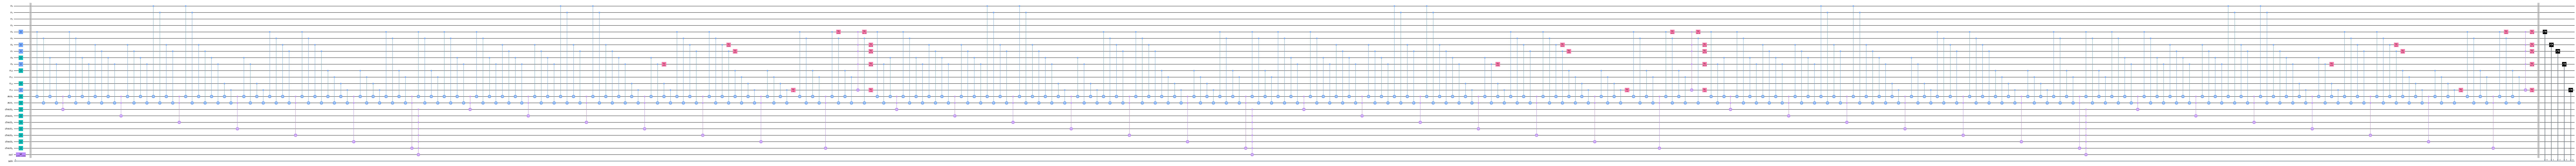

In [17]:
display_qc(transpiled_qc)

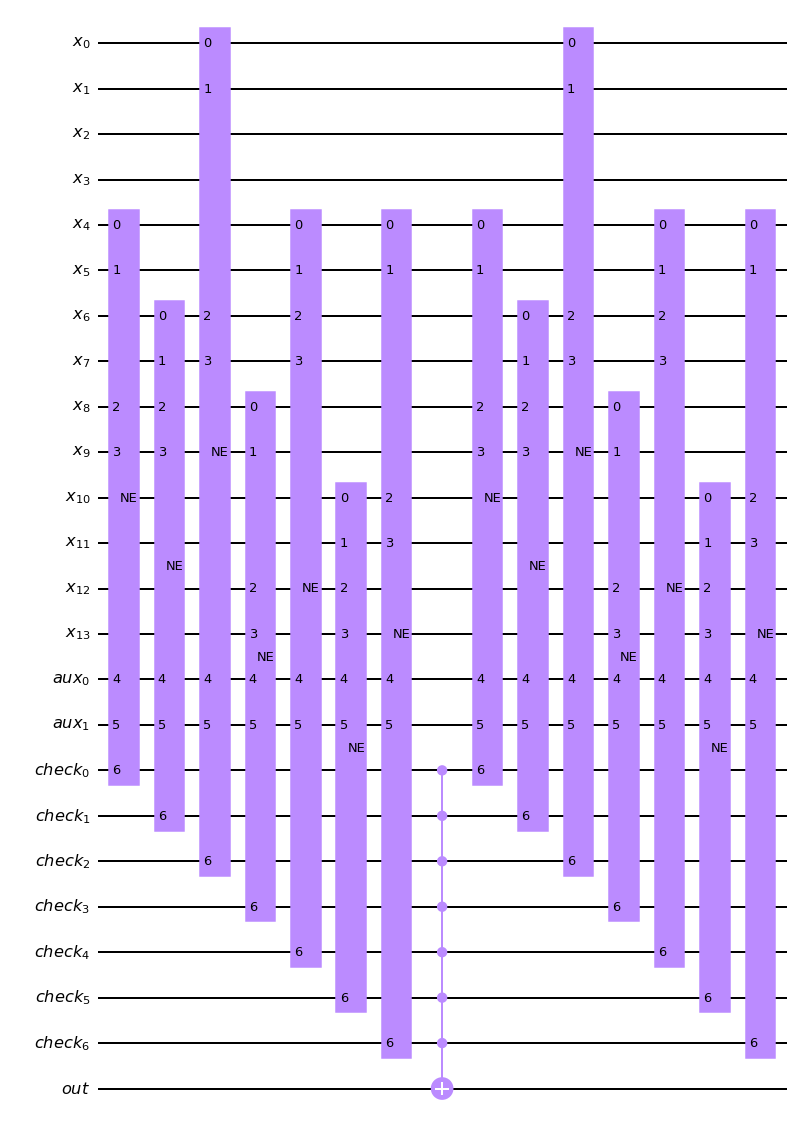

In [18]:
display_qc(solver.oracle.qc)

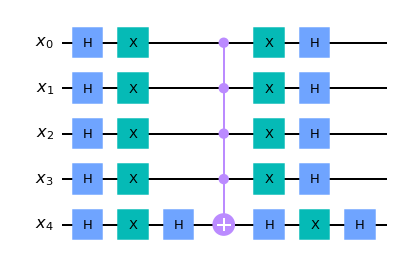

In [19]:
display_qc(solver.diff.qc)

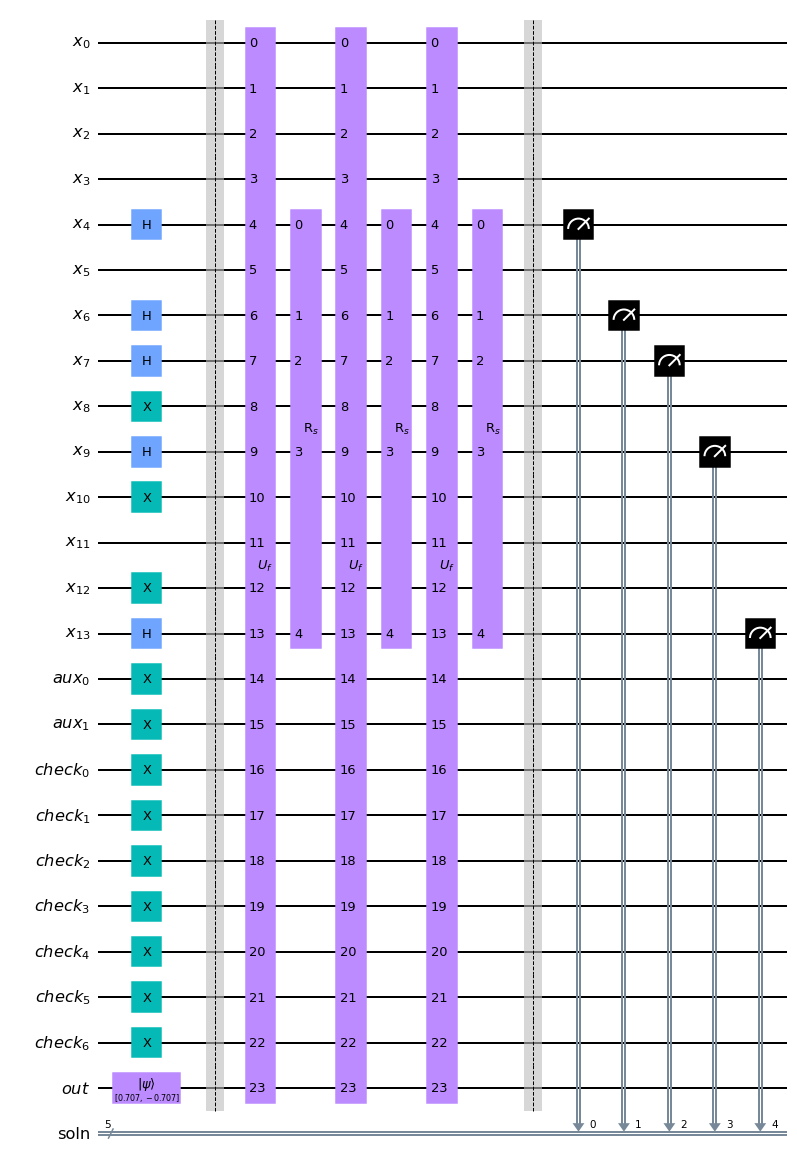

In [20]:
display_qc(solver.qc)